In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from visdom import Visdom
from callRate import plot_confusion_matrix, plot_ROC

plt.ion()   # interactive mode

In [2]:
# viz = Visdom()
# viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss'))
# viz.line([[0.0, 0.0]], [0.], win='test', opts=dict(title='test loss&acc.',
#                                                     legend=['loss', 'acc.']))

viz = Visdom(env='crack_classification')
viz.line([[0.0, 0.0]], [0.], win='Train', opts=dict(title = 'Train',
                                                    legend = ['Loss', 'Accuracy'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[51, 153, 255], 
                                                                [225, 102, 102]]),
                                                    dash=np.array(['dashdot','dashdot'])))
viz.line([[0.0, 0.0]], [0.], win='Test', opts=dict(title='Test',
                                                    legend=['Loss', 'Accuracy'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[51, 153, 255], 
                                                                [225, 102, 102]]),
                                                    dash=np.array(['dashdot','dashdot'])))

Setting up a new session...


'Test'

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/crackSubImageForTraining'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

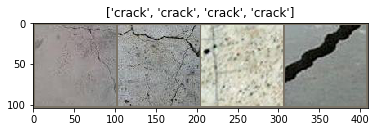

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    global_step = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        global_step += 1
        cm_labels = []
        cm_preds = []
        total_outputs = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            class_correct = list(0. for i in range(num_classes))
            class_total = list(0. for i in range(num_classes))
            class_acc = {} 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                           

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                if phase == 'test':
                    cm_labels += labels.tolist()
                    cm_preds += preds.tolist()
                    total_outputs += outputs.cpu().numpy().tolist()
                    res = preds.eq(labels)
                    for label_idx in range(len(labels)):
                        label_single = labels[label_idx]
                        class_correct[label_single] += res[label_idx].item()
                        class_total[label_single] += 1
                        
               
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels).float().sum().item()
                                
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                viz.line([[epoch_loss, epoch_acc]],[global_step],win = 'Train', update='append')
                
            if phase == 'test':
                viz.line([[epoch_loss,epoch_acc]],
                          [global_step], win = 'Test', update = 'append')
                for i in range(num_classes):
                    if class_total[i] == 0:
                        accuracy = 0
                    else:
                        accuracy = class_correct[i]/class_total[i]                        
                    class_acc[class_names[i]] = accuracy
                    viz.line([accuracy], [global_step], win = class_names[i], update = 'append')
                print(class_acc)
                
                
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
               
            

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_labels = cm_labels
                best_preds = cm_preds
                best_outputs = total_outputs
                best_model_wts = copy.deepcopy(model.state_dict())
            
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
    plot_confusion_matrix(best_labels, best_preds, classes = class_names, normalize = True)
    fpr, tpr, precision, recall, f1, specificity = plot_ROC(best_labels, best_preds, best_outputs, class_names = class_names)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, fpr, tpr, precision, recall, f1, best_labels, best_preds, best_outputs, specificity 

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# model_ft = models.vgg16(pretrained=True)
# model_ft.classifier[6] = nn.Linear(4096, num_classes)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features


# model_ft = nn.DataParallel(model_ft, device_ids=[1]) #multi-GPU
model_ft = model_ft.to(device)

#loss functions
# FL = FocalLoss(class_num = num_classes, gamma = 3) #focal loss

CE = nn.CrossEntropyLoss() #cross entropy loss

criterion = CE

# Observe that all parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Epoch 0/19
----------
train Loss: 0.5992 Acc: 0.7811
{'crack': 0.8357915437561455, 'nocrack': 0.9217777777777778}
test Loss: 0.2953 Acc: 0.8810
Epoch 1/19
----------
train Loss: 0.3248 Acc: 0.8765
{'crack': 0.9351032448377581, 'nocrack': 0.88}
test Loss: 0.2398 Acc: 0.9062
Epoch 2/19
----------
train Loss: 0.2366 Acc: 0.9100
{'crack': 0.9695181907571289, 'nocrack': 0.8648888888888889}
test Loss: 0.2431 Acc: 0.9146
Epoch 3/19
----------
train Loss: 0.1933 Acc: 0.9260
{'crack': 0.8515240904621436, 'nocrack': 0.9395555555555556}
test Loss: 0.2488 Acc: 0.8978
Epoch 4/19
----------
train Loss: 0.1697 Acc: 0.9357
{'crack': 0.9665683382497542, 'nocrack': 0.896}
test Loss: 0.2180 Acc: 0.9295
Epoch 5/19
----------
train Loss: 0.0742 Acc: 0.9746
{'crack': 0.9242871189773845, 'nocrack': 0.9404444444444444}
test Loss: 0.1946 Acc: 0.9328
Epoch 6/19
----------
train Loss: 0.0550 Acc: 0.9816
{'crack': 0.9370698131760079, 'nocrack': 0.936}
test Loss: 0.1969 Acc: 0.9365
Epoch 7/19
----------
train Loss

IndexError: index 1 is out of bounds for axis 1 with size 1

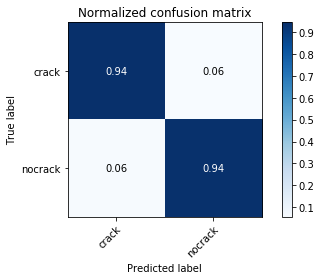

In [8]:
model, fpr, tpr, precision, recall, f1, best_labels, best_preds, best_outputs, specificity = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

In [ ]:
visualize_model(model_ft)